# Small-Scale Mining sites detection from Multi-spectral satellite image using FCN DK-6 architecture of Fully Connected Networks (FCN)

In this work I trained the FCN (DK-6) model to build an application which automatically detect Small-Scale Mines on the satellite image. I trained the model for two classes only. The tiles used came from a Sentinel satellite image acquired in 2020. The task is formulated as a binary classification problem distinguishing "Mines sites" from "others" classes based on semantic segmentation which is a pixel-wise classification.

We follow the steps bellow:
-Dataset preparation
-Train the model
-Test the model




The implementation is based on colab

## Part 1: Data preparation

In this part we prepare the input data for the model.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dependencies

In [2]:
# import the packages 
import os
import numpy as np
import gdal
import keras
import tensorflow as tf
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure

Populating the interactive namespace from numpy and matplotlib


In [3]:
# define dataset directory

from google.colab import drive

BASE_PATH = "/content/drive/My Drive/AIA_FCN_EX/Mines/Dataset"
IMAGE_PATH = os.path.join(BASE_PATH, "raw_images")
LABEL_PATH = os.path.join(BASE_PATH, "labels")

print(IMAGE_PATH)
print(LABEL_PATH)

/content/drive/My Drive/AIA_FCN_EX/Mines/Dataset/raw_images
/content/drive/My Drive/AIA_FCN_EX/Mines/Dataset/labels


In [5]:
# Structuring input data in 3D arrays

def gtiff_to_array(file_path):
    """Takes a file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis=2)


def fetch_tiles(path):
    """Parse the images into a dictionary of numpy arrays.
    
    The following keys are used:
    sat -- satellite image
    bldg -- for the building locations reference image
    road -- for the road locations reference image
    """
    tiles = {}
    for f in sorted(os.listdir(path)):
        fdir = os.path.join(path, f)
        _, ext = os.path.splitext(f)
        if ext.lower() == ".tif":
            imgtype = f[-10:-4]
            tiles[imgtype] = gtiff_to_array(fdir)
    return tiles

    
image_tiles = fetch_tiles(IMAGE_PATH)
label_tiles = fetch_tiles(LABEL_PATH)
   

In [6]:
#Inspection of shape of input data
print(image_tiles['1'].shape) # is the name of the tile

(650, 650, 3)


Visualization of input data

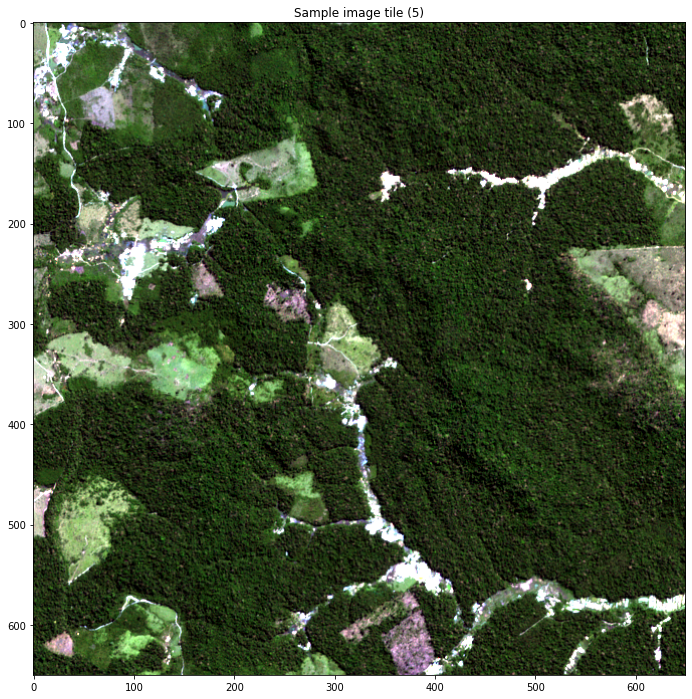

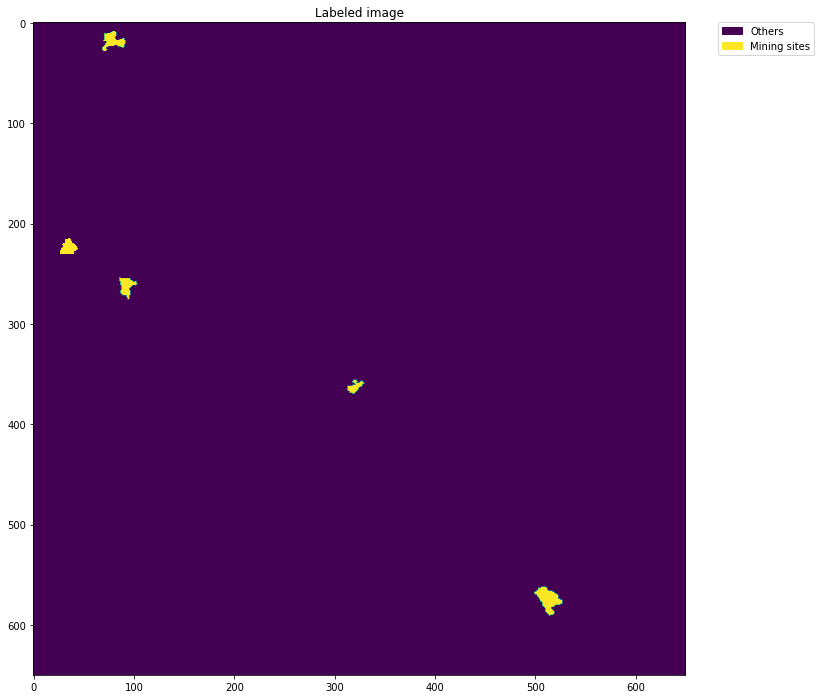

In [7]:
def visualize_labels(labels, fig_width=15, fig_height=12):
    """Visualize the labels prepared from the reference images."""
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    values = np.unique(labels.ravel())
    im = plt.imshow(labels[:,:,0])
    a.set_title("Labeled image")
    # get the colors of the values, according to the 
    # colormap used by imshow
    colors = [im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    labels = ["Others", "Mining sites"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), labels)]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def visualize_data(data, title, fig_width=15, fig_height=12):
    """Visualize the satellite image data."""
    # visualize only RGB bands
    data = data[:, :, 0:3]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    # perform stretching for better visualization
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    a.set_title(title)
    plt.imshow(data)

    

visualize_data(image_tiles["5"], "Sample image tile (5)")
visualize_labels(label_tiles["5"])

Sampling the input data for the model

In [8]:
PATCHSIZE = 128
NBANDS = image_tiles["1"].shape[-1]

def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)



Spliting dataset into training (70%) and testing (30%)

In [9]:
#Training Tiles
train_areas = ["1", "2", "3", "4", "5", "6","7", "8", "9","10", "11", "12", "13", "14", "15", "16","17", "18"] 

# Testing Tiles
test_areas = ["19", "20", "21", "22", "23", "24","25", "26", "27"]

In [10]:
# sample each training tile systematically in a gridwise manner
for tile in train_areas:
    X_toadd = gridwise_sample(image_tiles[tile], PATCHSIZE)
    Y_toadd = gridwise_sample(label_tiles[tile], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)

# encode all non-mining areas as one class
Ytrain[Ytrain!=2] = 1
print("There are %i number of training patches" % (Xtrain.shape[0]))
print("There are %i number of label patches" % (Ytrain.shape[0]))

There are 450 number of training patches
There are 450 number of label patches


Let's check if patches and their associated labels look all right

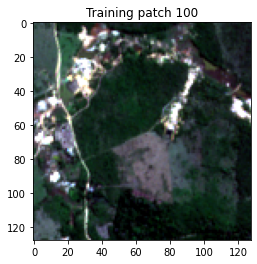

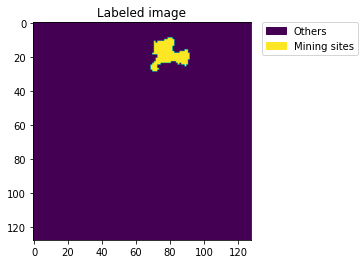

In [11]:
# Check if training patches looks all right
PATCH_NO = 100
visualize_data(Xtrain[PATCH_NO], "Training patch "+str(PATCH_NO), 4, 4)
visualize_labels(Ytrain[PATCH_NO], 4, 4)


## Part 2: Train the underlying base model and the FCN DK-6 model

Dependencies for the model

In [14]:
import tensorflow as tf
import keras
#from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.optimizers import SGD, Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#import tensorflow.python.keras.backend as K
#self.sess=tf.compat.v1.session()

#sess = K.get_session()
from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.compat.v1.Session(config=config))

In [15]:
#Parameters
NUMBER_BANDS = 3
NUMBER_CLASSES = 2
NUMBER_EPOCHS = 100

In [16]:
#Conversion of labeled array into hot encoding
def to_categorical_4d(y, nc):
    """Convert a reclassed ground truth array to one-hot encoding
    
    Keyword arguments:
    y -- ground truth image
    nc -- number of classes
    """
    Y = np.zeros((y.shape[0],
                  y.shape[1],
                  y.shape[2],
                  nc),
                  dtype=np.int32)
    for h in range(y.shape[0]):
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                if y[h, i, j, 0] != 0:
                    Y[h, i, j, y[h, i, j, 0]-1] = 1
                else:
                    continue
    return Y

# transform target arrays to one-hot encodings
Ytrain = to_categorical_4d(Ytrain, 2)

Building the underlying FCN model

In [17]:
def build_FCN(optimizer, nrows, ncols, nbands, nclasses):
    """Function to create Keras model of sample network."""
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape=(nrows, ncols, nbands)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(7, 7),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
              pool_size=(3, 3),
              strides=(1, 1)
    ))
    model.add(ZeroPadding2D((2, 2)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(Activation("relu"))
    model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(1, 1)
    ))
    model.add(keras.layers.Conv2D(
              filters=nclasses,
              kernel_size=(1, 1)
    ))
    model.add(keras.layers.Activation(
              activation="softmax"
    ))
    model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
    return model


Metrics for model behaviour 

In [19]:

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Additional metrics

def pixel_wise_loss(y_true, y_pred):
    pos_weight = tf.constant([[1.0, 2.0]])
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        y_pred,
        pos_weight,
        name=None
    )
    return K.mean(loss,axis=-1)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coef = (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    return coef


Defining the model

In [23]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.3)
fcn = build_FCN(opt, PATCHSIZE, PATCHSIZE, NUMBER_BANDS,NUMBER_CLASSES)

fcn.compile(optimizer=opt, loss='binary_crossentropy', metrics=[precision_m, pixel_wise_loss, dice_coef, f1_m, recall_m, "accuracy"])



In [24]:
print (fcn.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_12 (ZeroPaddi (None, 134, 134, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      4736      
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
activation_9 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 130, 130, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 132, 132, 32)     

Training the underlying FCN model

In [25]:
def train(model, data, labels):
    hist = model.fit(x=data,
                     y=labels,
                     epochs=NUMBER_EPOCHS,
                     verbose=2
                    )
    return hist

history = train(fcn, Xtrain, Ytrain)

Epoch 1/100
15/15 - 8s - loss: 0.4802 - precision_m: 0.9398 - pixel_wise_loss: 0.6168 - dice_coef: 0.7389 - f1_m: 0.9398 - recall_m: 0.9398 - accuracy: 0.9362
Epoch 2/100
15/15 - 0s - loss: 0.3246 - precision_m: 0.9923 - pixel_wise_loss: 0.5576 - dice_coef: 0.8726 - f1_m: 0.9923 - recall_m: 0.9923 - accuracy: 0.9919
Epoch 3/100
15/15 - 0s - loss: 0.2466 - precision_m: 0.9934 - pixel_wise_loss: 0.5356 - dice_coef: 0.9247 - f1_m: 0.9934 - recall_m: 0.9934 - accuracy: 0.9930
Epoch 4/100
15/15 - 0s - loss: 0.1935 - precision_m: 0.9946 - pixel_wise_loss: 0.5240 - dice_coef: 0.9517 - f1_m: 0.9946 - recall_m: 0.9946 - accuracy: 0.9943
Epoch 5/100
15/15 - 0s - loss: 0.1620 - precision_m: 0.9937 - pixel_wise_loss: 0.5189 - dice_coef: 0.9656 - f1_m: 0.9937 - recall_m: 0.9937 - accuracy: 0.9938
Epoch 6/100
15/15 - 0s - loss: 0.1359 - precision_m: 0.9946 - pixel_wise_loss: 0.5149 - dice_coef: 0.9746 - f1_m: 0.9946 - recall_m: 0.9946 - accuracy: 0.9946
Epoch 7/100
15/15 - 0s - loss: 0.1190 - precis

Plotting learning curve

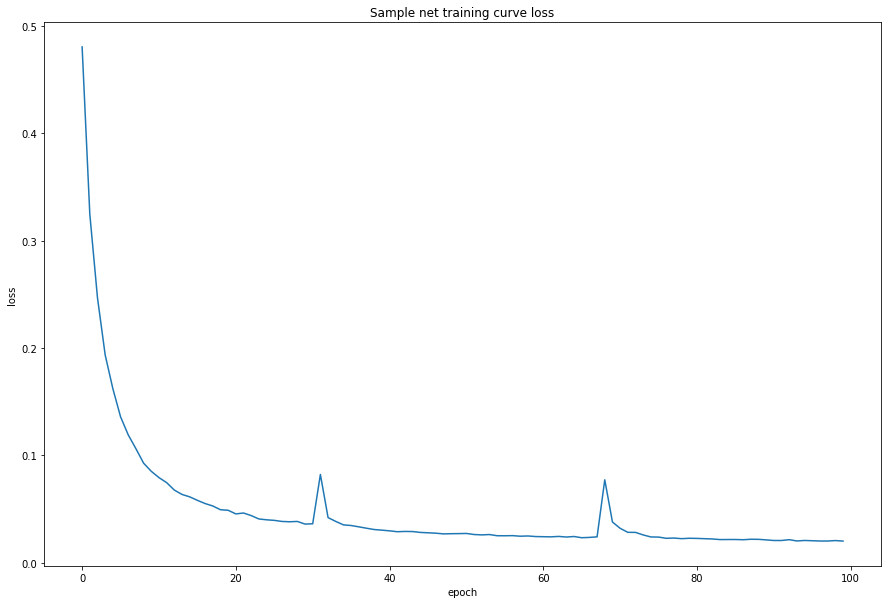

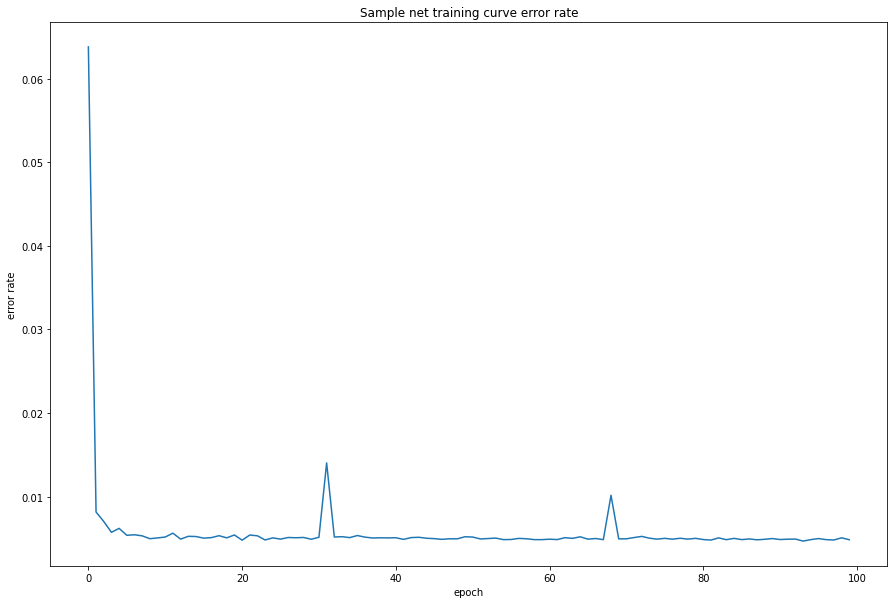

In [26]:
# plot learning curve
plt.plot(history.history["loss"])
plt.title("Sample net training curve loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
plt.plot(1-np.array(history.history["accuracy"]))
plt.title("Sample net training curve error rate")
plt.ylabel("error rate")
plt.xlabel("epoch")
plt.show()

Dependencies of the SegNet model

In [27]:
from keras.layers import LeakyReLU
import pickle
import matplotlib.pyplot as plt 
import sys
sys.path.append("/content/drive/My Drive/AIA_FCN_EX/Mines/Dataset")

Building and defining the FCN-DK6 model

In [29]:
def build_DK6(optimizer, nrows, ncols, nbands, nclasses):
    """Model builder function for FCN-DK6."""
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((2, 2), input_shape=(nrows, ncols, nbands)))
    model.add(Convolution2D(
              filters=16,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((2, 2)))
    model.add(MaxPooling2D(
              pool_size=(5, 5),
              strides=(1, 1)
    ))
    model.add(ZeroPadding2D((4, 4)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(2, 2)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((4, 4)))
    model.add(MaxPooling2D(
            pool_size=(9, 9),
            strides=(1, 1)
    ))
    model.add(ZeroPadding2D((6, 6)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(3, 3)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((6, 6)))
    model.add(MaxPooling2D(
            pool_size=(13, 13),
            strides=(1, 1)
    ))
    model.add(Convolution2D(
              filters=nclasses,
              kernel_size=(1, 1)
    ))
    model.add(keras.layers.Activation(
              activation="softmax"
    ))
    model.compile(loss="Categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
    return model

opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.2)
DK6 = build_DK6(opt, PATCHSIZE, PATCHSIZE, NUMBER_BANDS, 2)

DK6.compile(optimizer=opt, loss='binary_crossentropy', metrics=[precision_m, pixel_wise_loss, dice_coef, f1_m, recall_m, 'acc'])

print(DK6.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_22 (ZeroPaddi (None, 132, 132, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 16)      1216      
_________________________________________________________________
batch_normalization_11 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
zero_padding2d_23 (ZeroPaddi (None, 132, 132, 16)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
zero_padding2d_24 (ZeroPaddi (None, 136, 136, 16)     

Training the FCN-DK6 model

In [31]:
history = train(DK6, Xtrain, Ytrain)

Epoch 1/100
15/15 - 3s - loss: 0.4336 - precision_m: 0.9783 - pixel_wise_loss: 0.6014 - dice_coef: 0.7762 - f1_m: 0.9783 - recall_m: 0.9783 - acc: 0.9775
Epoch 2/100
15/15 - 1s - loss: 0.3370 - precision_m: 0.9893 - pixel_wise_loss: 0.5682 - dice_coef: 0.8532 - f1_m: 0.9893 - recall_m: 0.9893 - acc: 0.9894
Epoch 3/100
15/15 - 1s - loss: 0.2931 - precision_m: 0.9885 - pixel_wise_loss: 0.5545 - dice_coef: 0.8820 - f1_m: 0.9885 - recall_m: 0.9885 - acc: 0.9881
Epoch 4/100
15/15 - 1s - loss: 0.2630 - precision_m: 0.9875 - pixel_wise_loss: 0.5462 - dice_coef: 0.9000 - f1_m: 0.9875 - recall_m: 0.9875 - acc: 0.9902
Epoch 5/100
15/15 - 1s - loss: 0.2395 - precision_m: 0.9892 - pixel_wise_loss: 0.5396 - dice_coef: 0.9159 - f1_m: 0.9892 - recall_m: 0.9892 - acc: 0.9897
Epoch 6/100
15/15 - 1s - loss: 0.2215 - precision_m: 0.9904 - pixel_wise_loss: 0.5350 - dice_coef: 0.9218 - f1_m: 0.9904 - recall_m: 0.9904 - acc: 0.9907
Epoch 7/100
15/15 - 1s - loss: 0.2070 - precision_m: 0.9915 - pixel_wise_los

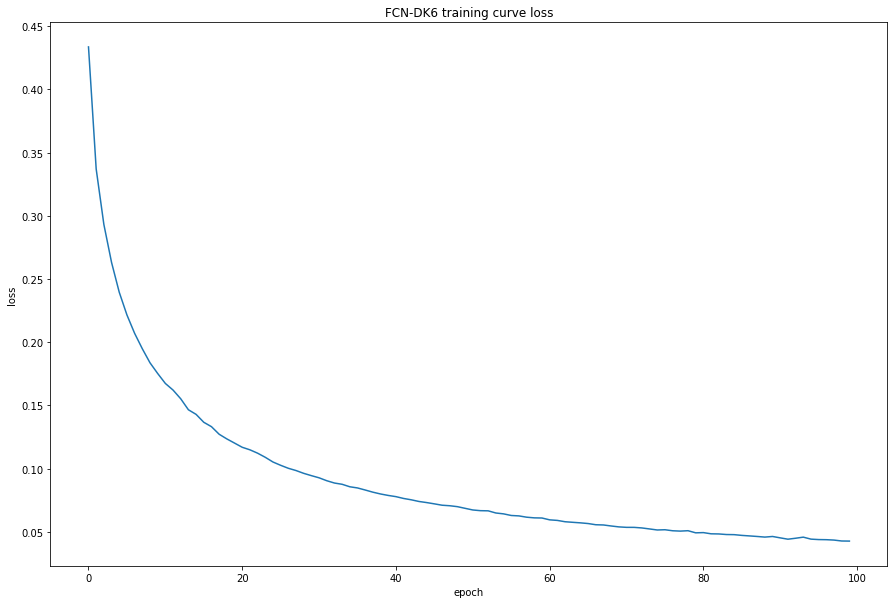

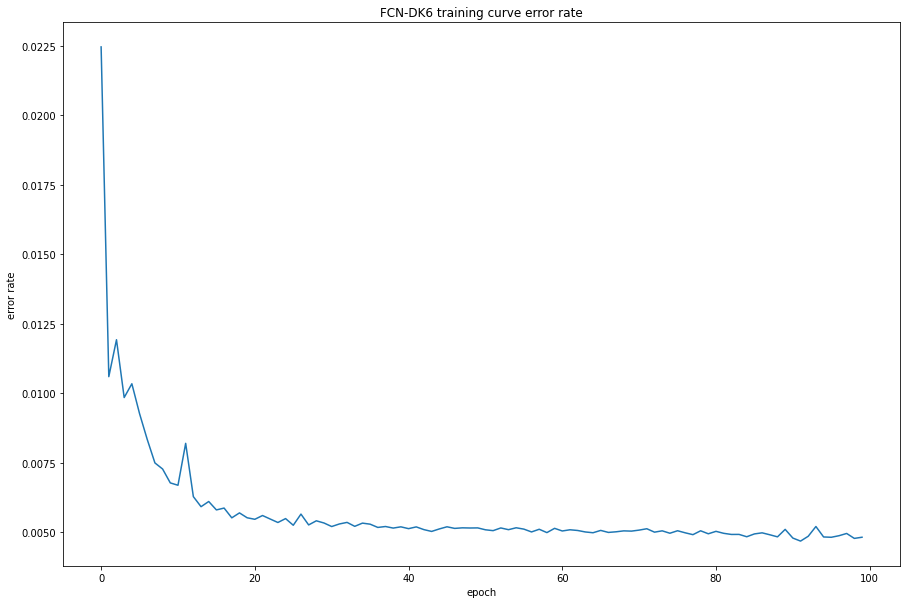

In [32]:
# plot the learning curve of FCN-DK6
plt.plot(history.history["loss"])
plt.title("FCN-DK6 training curve loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
plt.plot(1-np.array(history.history["acc"]))
plt.title("FCN-DK6 training curve error rate")
plt.ylabel("error rate")
plt.xlabel("epoch")
plt.show()

##Part 3: Testing the FCN_DK6 model

This part illustrates the evaluation of the performannce of the SegNet model

In [33]:
# we test the model on tile 25 (used by each group member for results comparison)
Xtest = image_tiles["25"]
Ytest = label_tiles["25"]

In [34]:
cut = 128
overlap = 96

In [36]:
# Evaluation of the underlying FCN model on test tile

def evaluate_predictions(Xtest,cut, overlap, Ytest):
    """
    Function to predict full tiles strip-wise (as loading whole tiles might not fit in the memory).
    """
    Ytest = Ytest.copy()
    Ytest[Ytest!=2] = 0
    Ytest[Ytest==2] = 1
    ncols, nrows, nbands = Xtest.shape
    Xtest = np.expand_dims(Xtest, axis=0)
    total_map = np.zeros((nrows, ncols), dtype=np.uint8)
    first = True
    last = False
    if nrows%cut==0:
        numstrips = int(nrows/cut)
    else:
        numstrips = int(nrows/cut) + 1
    for i in range(numstrips):
        print("Strip number: %d" % i)
        if first:
            striptop = 0
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
            first = False
        elif (not first) and (cut*(i+1)+1+overlap < nrows):
            striptop = overlap
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
        else:
            print("Last hit!")
            striptop = overlap
            stripbottom = 0
            height = nrows - cut*i
            if (striptop+height)%(4)!=0:
                height = height*4
            X_sub = Xtest[:, -(striptop+height):, :, :]
            last = True        
        sub_nrows = X_sub.shape[1]
        sub_ncols = X_sub.shape[2]
        model = fcn
        
        sub_ns, sub_nb, _, __ = X_sub.shape
        cmap = model.predict_on_batch([X_sub])
        cmap = np.argmax(cmap[0], axis=2)
        if not last:
            total_map[cut*i:cut*i+height, :] = cmap[striptop:striptop+height, 0:total_map.shape[1]]
        else:
            total_map[-(height):, :] = cmap[-(height):, 0:total_map.shape[1]]
    return total_map

predictions_FCN = evaluate_predictions(Xtest, cut, overlap, Ytest)

Strip number: 0
Strip number: 1
Strip number: 2
Strip number: 3
Strip number: 4
Last hit!
Strip number: 5
Last hit!


In [38]:
# Evaluation of the FCN-DK6 model on test tile 

def evaluate_predictions_dk6(Xtest, cut, overlap, Ytest):
    """
    Function to predict full tiles strip-wise (as loading whole tiles might not fit in the memory).
    """
    Ytest = Ytest.copy()
    Ytest[Ytest!=2] = 0
    Ytest[Ytest==2] = 1
    ncols, nrows, nbands = Xtest.shape
    Xtest = np.expand_dims(Xtest, axis=0)
    total_map = np.zeros((nrows, ncols), dtype=np.uint8)
    first = True
    last = False
    if nrows%cut==0:
        numstrips = int(nrows/cut)
    else:
        numstrips = int(nrows/cut) + 1
    for i in range(numstrips):
        print("Strip number: %d" % i)
        if first:
            striptop = 0
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
            first = False
        elif (not first) and (cut*(i+1)+1+overlap < nrows):
            striptop = overlap
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
        else:
            print("Last hit!")
            striptop = overlap
            stripbottom = 0
            height = nrows - cut*i
            if (striptop+height)%(4)!=0:
                height = height*4
            X_sub = Xtest[:, -(striptop+height):, :, :]
            last = True        
        sub_nrows = X_sub.shape[1]
        sub_ncols = X_sub.shape[2]
        model = DK6
        
        sub_ns, sub_nb, _, __ = X_sub.shape
        cmap = model.predict_on_batch([X_sub])
        cmap = np.argmax(cmap[0], axis=2)
        if not last:
            total_map[cut*i:cut*i+height, :] = cmap[striptop:striptop+height, 0:total_map.shape[1]]
        else:
            total_map[-(height):, :] = cmap[-(height):, 0:total_map.shape[1]]
    return total_map
  
predictions_DK6 = evaluate_predictions_dk6(Xtest, cut, overlap, Ytest)

Strip number: 0
Strip number: 1
Strip number: 2
Strip number: 3
Strip number: 4
Last hit!
Strip number: 5
Last hit!


Implementation of evaluation and visualization of the results

In [39]:
def print_map(predictions, idxarray, filename=None, title=None, ccolors=None):
    """Print the classified map.

    Keyword arguments:
    predictions -- the array output labels from the classification
    results
    idxarray -- the array of indices of the classified samples
    to be plotted.
    filename -- the name (with the directory) of the file where to
    write the map.
    ccolors -- an array of tuples containing rgb values for the classes
    Both arrays should match and be arranged accordingly. And the
    index of the color should match the value of the of prediction.
    """
    if predictions.size != idxarray.shape[0]:
        raise ValueError("There should be the same number of " +
                         "predictions and indices.")
    nrows, ncols = np.max(idxarray[:, 0])+1, np.max(idxarray[:, 1])+1
    classifiedmap = np.zeros((nrows, ncols, 3), dtype="uint8")
    idx = 0
    for prediction in predictions:
        classifiedmap[idxarray[idx, 0],
                      idxarray[idx, 1]] = np.asarray(ccolors[prediction])
        idx += 1
    if filename is None:
        fig = plt.figure()
        plt.imshow(classifiedmap)
        if title:
            plt.suptitle(title)
        plt.show()
    else:
        output_raster = gdal.GetDriverByName('GTiff').Create(filename,
                                                             NCOLS,
                                                             NROWS,
                                                             NUMBER_CLASSES,
                                                             gdal.GDT_Byte)
        for i in range(NUMBER_CLASSES):
            output_raster.GetRasterBand(i+1).WriteArray(classifiedmap.astype(np.uint8)[:, :, i])


def get_confusion_matrix(predictions, labels):
    """Compute the confusion matrix.

    Keyword arguments:
    prediction -- the array output labels from the classification
    results
    labels -- the  array of "true" labels from the test set
    Both arrays should match, be arranged accordingly, and
    have non-negative values.
    """
    classes = np.unique(labels)
    nbclasses = classes.size
    if labels.size != predictions.size:
        raise ValueError("There should be the same number of " +
                         "predictions and labels.")
    merged = np.concatenate((predictions.reshape(predictions.size, 1),
                             labels.reshape(labels.size, 1)), axis=1)
    CM = np.zeros((classes[-1] + 1, classes[-1] + 1))
    for c1 in classes:
        for c2 in classes:
            CM[c1, c2] = np.sum(np.logical_and(merged[:, 1] == c1,
                                               merged[:, 0] == c2))
    return CM


def cartesian(arrays, out=None):
    """Utility function to create cartesian image coordinates."""
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype
    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)
    m = int(n / arrays[0].size)
    out[:, 0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

In [40]:
import string
from matplotlib import colors
from sklearn.metrics import f1_score, precision_score, recall_score
# set color codes of the classes
_mines = [0, 0, 0]
_others = [220, 220, 214]
ccolors = (_mines, _others)
NROWS, NCOLS, NBANDS = Xtest.shape

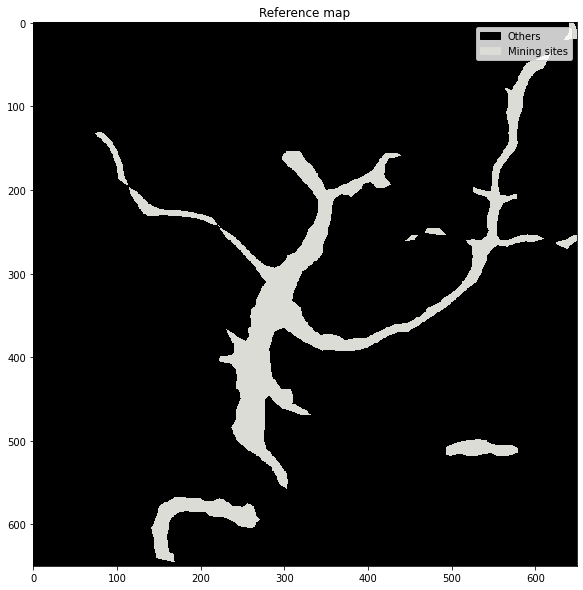

Accuracy metrics of FCN results
Overall Accuracy: 0.946800
F1_score: 0.282846
PA of others: 0.995037
PA of mining sites: 0.320514


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


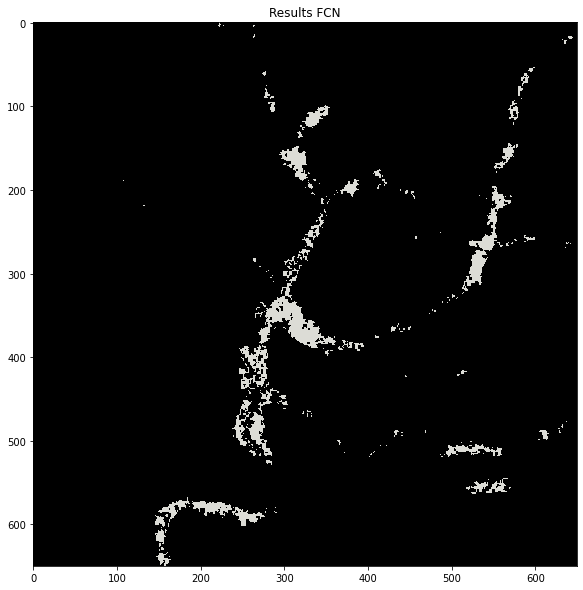

Accuracy metrics of FCN-DK6 results
Overall Accuracy: 0.930578
F1_score: 0.025608
PA of others: 0.999735
PA of mining sites: 0.032667


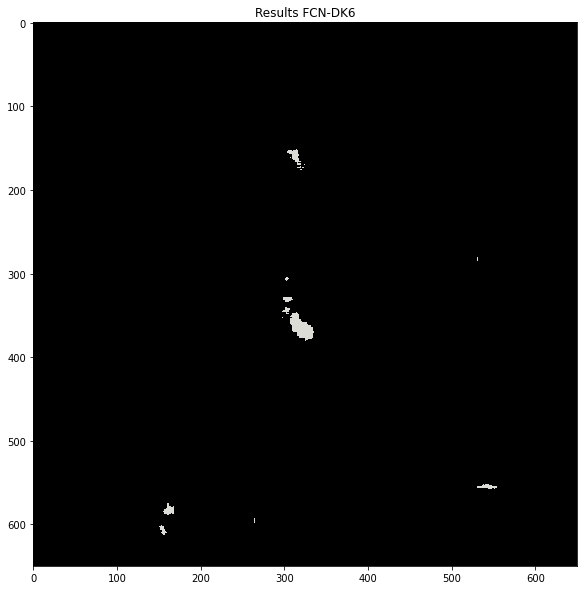

In [42]:
# plot reference map
norm_ccolors = np.array(ccolors)/255.0
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
cmap = colors.ListedColormap(norm_ccolors)
bounds=[0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)
labels = Ytest[:, :, 0].copy()
labels[labels!=2] = 0
labels[labels==2] = 1
ax.imshow(labels, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
ax.set_title("Reference map")
rectangles = [matplotlib.patches.Rectangle((0, 0), 1, 1, color=norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = ["Others", "Mining sites"]
#Create legend from custom artist/label lists
ax.legend(rectangles, classes)
plt.show()
labels = labels.astype("uint8")

# evaluate FCN
predictions = predictions_FCN
mapidx = cartesian([range(predictions.shape[0]), range(predictions.shape[1])])
CM = get_confusion_matrix(predictions, labels)
OA = np.sum(np.diag(CM))/predictions.size
PA_bldg = ((predictions[labels==0]==labels[labels==0]).sum())/(labels[labels==0].size)
PA_rd = ((predictions[labels==1]==labels[labels==1]).sum())/(labels[labels==1].size)
mapfname = "map_FCN.tif"
print("Accuracy metrics of FCN results")
print("Overall Accuracy: %f" % OA)
print("F1_score: %f" %(f1_score(labels, predictions, average="macro")))
print("PA of others: %f" % PA_bldg)
print("PA of mining sites: %f" % PA_rd)
predictions_ = predictions.flatten()
print_map(predictions_, mapidx, ccolors=ccolors, filename=mapfname)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(predictions, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
ax.set_title("Results FCN")
plt.show()     

# evaluate SegNet
predictions = predictions_DK6
mapidx = cartesian([range(predictions.shape[0]), range(predictions.shape[1])])
CM = get_confusion_matrix(predictions, labels)
OA = np.sum(np.diag(CM))/predictions.size
PA_bldg = ((predictions[labels==0]==labels[labels==0]).sum())/(labels[labels==0].size)
PA_rd = ((predictions[labels==1]==labels[labels==1]).sum())/(labels[labels==1].size)
mapfname = "map_FCNDK6.tif"
print("Accuracy metrics of FCN-DK6 results")
print("Overall Accuracy: %f" % OA)
print("F1_score: %f" %(f1_score(labels, predictions, average="macro")))
print("PA of others: %f" % PA_bldg)
print("PA of mining sites: %f" % PA_rd)
predictions_ = predictions.flatten()
print_map(predictions_, mapidx, ccolors=ccolors, filename=mapfname)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(predictions, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
ax.set_title("Results FCN-DK6")
plt.show()